# Bayesian analysis of QB TDs / game

This approach is a rough first pass at running bayesian analysis on a particular NFL metric.

## approach

The data used to inform the model is a set of statistics of all QBs who played full (16-game) seasons from 2009-2015. The resulting dataset is 1456 games, amounting to 91 player-seasons.

All player-seasons are bucketed into 5 'buckets' depending on a simple heuristic of average touchdowns over the course of the season (from 0.5 to 2.5 in increments of 0.5). These are defined in order as:

```
buckets = {
    1: 'bad',
    2: 'meh',
    3: 'ok',
    4: 'good',
    5: 'great',
}
```

The normalized histogram of this bucketing scheme is the **prior** of the model - in other words, how likely it is that a given player is bad, meh, ok, good, or great.

The **likelihood** of the model is defined by the probability of scoring `x` touchdowns in a game for each bucket. If a QB is bad, his probability of scoring 0-1 touchdowns is much higher than a great QB's. For example, Geno Smith had an abysmal 2013, averaging 0.75 touchdowns per game, whereas Drew Brees in 2011 had an incredible season (2.88 touchdowns per game). Geno's TD probability distribution is going to be heavily skewed to the left, whereas Drew's will look closer to a bell curve. These players's seasons are analyzed at the end of the notebook.

Even though this model is crude, it will ideally adapt to a player's performance over the course of a season in at least a qualitative way (i.e. we won't be confused when we look at graphs in extreme cases). Starting from no evidence at the beginning of a season, we should continually get a better understanding of a player's performance week by week.

In [1]:
# stuff we need
import petl
import psycopg2
import matplotlib.pyplot as plt

# big inline graphs by default
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# suppress bullshit scipy warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# global connection for db
conn = psycopg2.connect('dbname=nfldb')

# pull data

In [101]:
# get season-level aggregate data
qb_agg = petl.fromdb(conn, 'select * from lombardi.qb_aggs')
qb_agg.head()

year,full_name,avg_yds,avg_tds,avg_int,avg_cmp,avg_att,std_yds,std_tds,std_int,std_cmp,std_att,num_games
2009,Aaron Rodgers,277.13,1.88,0.44,21.88,33.81,68.14,0.96,0.89,6.20,8.61,16
2009,Alex Smith,213.64,1.64,1.09,20.45,33.82,55.69,0.92,1.14,4.95,7.85,11
2009,Ben Roethlisberger,288.53,1.73,0.80,22.47,33.73,96.10,1.10,0.68,5.53,6.52,15
2009,Brian Hoyer,47.33,0.00,0.00,6.33,9.00,26.31,0.00,0.00,3.79,4.36,3
2009,Carson Palmer,193.38,1.31,0.81,17.63,29.13,77.50,1.30,0.75,5.77,8.06,16


In [103]:
buckets = {
    1: 'bad',
    2: 'meh',
    3: 'ok',
    4: 'good',
    5: 'great',
}

# filter by 16-game seasons and bucket
seasons = (
    qb_agg
    .selecteq('num_games', 16)
    .cut(('year', 'full_name', 'avg_tds'))
    .addfield('bucket_num', lambda r: int(float(r['avg_tds']) // 0.5))
    .addfield('bucket', lambda r: buckets[r['bucket_num']])
)
seasons.head()

year,full_name,avg_tds,bucket_num,bucket
2009,Aaron Rodgers,1.88,3,ok
2009,Carson Palmer,1.31,2,meh
2009,Eli Manning,1.69,3,ok
2009,Joe Flacco,1.31,2,meh
2009,Matt Schaub,1.81,3,ok


# pull game-level data for complete seasons

In [104]:
# pull game-level data
qb_games = petl.fromdb(conn, 'select * from lombardi.qb_stats')
qb_games.head()

year,week,full_name,yards,touchdowns,interceptions,attempts,completions
2009,1,Aaron Rodgers,184,1,0,28,17
2009,1,Ben Roethlisberger,363,1,2,43,33
2009,1,Carson Palmer,247,0,2,33,21
2009,1,Drew Brees,358,6,1,34,26
2009,1,Eli Manning,256,1,1,29,20


In [105]:
# join to complete seasons table to limit to just those seasons
games = (
    seasons
    .join(qb_games, key=(('year', 'full_name')), lprefix='b_', rprefix='g_')
    .cut(('b_year', 'b_full_name', 'g_week', 'g_touchdowns', 'b_avg_tds', 'b_bucket'))
    .rename({
        'b_year': 'year',
        'b_full_name': 'full_name',
        'g_week': 'week',
        'g_touchdowns': 'tds',
        'b_avg_tds': 'season_avg_tds',
        'b_bucket': 'season_bucket',
    })
)
games.tail()

year,full_name,week,tds,season_avg_tds,season_bucket
2015,Tom Brady,13,3,2.25,good
2015,Tom Brady,14,2,2.25,good
2015,Tom Brady,15,2,2.25,good
2015,Tom Brady,16,1,2.25,good
2015,Tom Brady,17,0,2.25,good


# determine bucket / touchdown probabilities (likelihood)

In [6]:
# make a table of all combos of buckets and touchdowns
# to use as reference
bucket_td_combos = petl.fromdicts([
    {'season_bucket': b, 'tds': t}
    for b in set(games['season_bucket'])
    for t in set(games['tds'])
])

In [10]:
bucket_tds = (
    bucket_td_combos
    .leftjoin(
        games.aggregate(key=('season_bucket', 'tds'), aggregation=len), 
        key=('season_bucket', 'tds'), 
        missing=0,
    )
    .rename({'value': 'count'})
)
bucket_tds.look()

+---------------+-----+-------+
| season_bucket | tds | count |
+===============+=====+=======+
| 'bad'         |   0 |    21 |
+---------------+-----+-------+
| 'bad'         |   1 |    19 |
+---------------+-----+-------+
| 'bad'         |   2 |     6 |
+---------------+-----+-------+
| 'bad'         |   3 |     1 |
+---------------+-----+-------+
| 'bad'         |   4 |     1 |
+---------------+-----+-------+
...

In [8]:
totals = bucket_tds.aggregate('season_bucket', sum, 'count').rename({'value': 'bucket_total'})
totals.lookall()

+---------------+--------------+
| season_bucket | bucket_total |
+===============+==============+
| 'bad'         |           48 |
+---------------+--------------+
| 'good'        |          320 |
+---------------+--------------+
| 'great'       |           64 |
+---------------+--------------+
| 'meh'         |          384 |
+---------------+--------------+
| 'ok'          |          624 |
+---------------+--------------+

In [9]:
bucket_td_probs = (
    bucket_tds
    .join(totals, key='season_bucket')
    .addfield('prob', lambda r: round(r['count'] / r['bucket_total'], 3))
    .rename('season_bucket', 'bucket')
)
bucket_td_probs.lookall()

+---------+-----+-------+--------------+-------+
| bucket  | tds | count | bucket_total | prob  |
+=========+=====+=======+==============+=======+
| 'bad'   |   0 |    21 |           48 | 0.438 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   1 |    19 |           48 | 0.396 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   2 |     6 |           48 | 0.125 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   3 |     1 |           48 | 0.021 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   4 |     1 |           48 | 0.021 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   5 |     0 |           48 |   0.0 |
+---------+-----+-------+--------------+-------+
| 'bad'   |   6 |     0 |           48 |   0.0 |
+---------+-----+-------+--------------+-------+
| 'good'  |   0 |    20 |          320 | 0.062 |
+---------+-----+-------+--------------+-------+
| 'good'  |   1 |    83 |          320 | 0.259 |
+---------+-----+---

# spot-check probability distributions for bad / great buckets

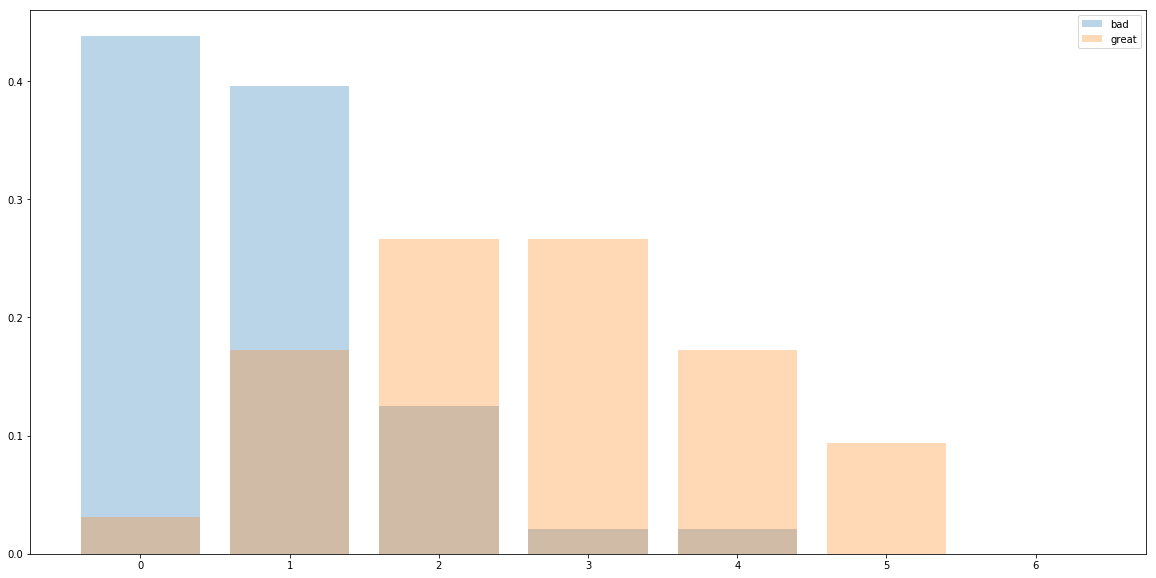

In [11]:
# compare touchdown count probabilities for bad vs great
plt.bar(
    left=range(7),
    height=list(bucket_td_probs.selecteq('bucket', 'bad')['prob']),
    alpha=0.3,
    label='bad',
)
plt.bar(
    left=range(7),
    height=list(bucket_td_probs.selecteq('bucket', 'great')['prob']),
    alpha=0.3,
    label='great',
)
plt.legend()

# get bucket probabilities (prior)

I.e. how often players suck versus how often they're amazing.

In [12]:
qb_season_count = len(seasons)

bucket_dist = (
    seasons
    .aggregate(('bucket', 'bucket_num'), len)
    .sort('bucket_num')
    .rename('value', 'count')
    .addfield('prob', lambda r: round(r['count']/qb_season_count, 3))
)
bucket_dist.lookall()

+---------+------------+-------+-------+
| bucket  | bucket_num | count | prob  |
+=========+============+=======+=======+
| 'bad'   |          1 |     3 | 0.033 |
+---------+------------+-------+-------+
| 'meh'   |          2 |    24 | 0.264 |
+---------+------------+-------+-------+
| 'ok'    |          3 |    39 | 0.429 |
+---------+------------+-------+-------+
| 'good'  |          4 |    20 |  0.22 |
+---------+------------+-------+-------+
| 'great' |          5 |     4 | 0.044 |
+---------+------------+-------+-------+

# remove extraneous fields in our probability tables

In [14]:
# reduce tables to only the data we care about
bucket_data = bucket_dist.cut(('bucket', 'prob'))
bucket_data

bucket,prob
bad,0.033
meh,0.264
ok,0.429
good,0.22
great,0.044


In [15]:
bucket_td_data = bucket_td_probs.cut(('bucket', 'tds', 'prob'))
bucket_td_data

bucket,tds,prob
bad,0,0.438
bad,1,0.396
bad,2,0.125
bad,3,0.021
bad,4,0.021


# Bayes Time 🎉

In [61]:
from lombardi import bayes

## format our tabular data so our module can consume it

In [62]:
bucket_probs_list = petl.dicts(bucket_data)
bucket_td_probs_list = petl.dicts(bucket_td_data)

In [63]:
bucket_probs_dict = bayes.Pdf({r['bucket']: r['prob'] for r in bucket_probs_list})
bucket_probs_dict

Pdf(probs={'bad': 0.033, 'meh': 0.264, 'ok': 0.429, 'good': 0.22, 'great': 0.044})

In [64]:
bucket_td_probs_dict = {r['bucket']: None for r in bucket_td_probs_list}
for b in bucket_td_probs_dict.keys():
    bucket_td_probs_dict[b] = bayes.Pdf({
        r['tds']: r['prob']
        for r in bucket_td_probs_list
        if r['bucket'] == b
    })
bucket_td_probs_dict

{'bad': Pdf(probs={0: 0.438, 1: 0.396, 2: 0.125, 3: 0.021, 4: 0.021, 5: 0.0, 6: 0.0}),
 'good': Pdf(probs={0: 0.062, 1: 0.259, 2: 0.319, 3: 0.216, 4: 0.1, 5: 0.034, 6: 0.009}),
 'great': Pdf(probs={0: 0.031, 1: 0.172, 2: 0.266, 3: 0.266, 4: 0.172, 5: 0.094, 6: 0.0}),
 'meh': Pdf(probs={0: 0.234, 1: 0.383, 2: 0.284, 3: 0.076, 4: 0.016, 5: 0.008, 6: 0.0}),
 'ok': Pdf(probs={0: 0.125, 1: 0.338, 2: 0.314, 3: 0.159, 4: 0.054, 5: 0.005, 6: 0.005})}

## create a discrete bayes object

In [65]:
dist = bayes.DiscreteBayes(
    prior=bucket_probs_dict,
    likelihoods=bucket_td_probs_dict,
)

## check expected touchdowns per game for the average QB

This uses our prior's buckets to generate a likelihood of touchdowns per game. Known as the **posterior predictive**.

<Container object of 7 artists>

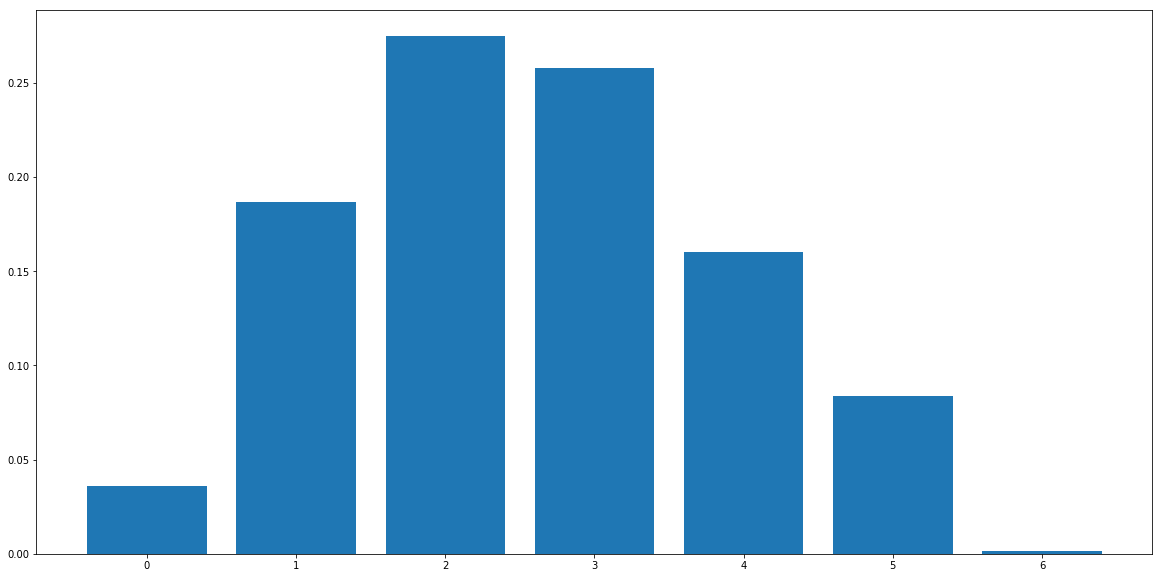

In [106]:
# view expected tds per game given no information about a player
plt.bar(range(7), list(dist.posterior_predictive().probs.values()))

## calculate expected value from posterior predictive

This is basically the number that fantasy sites generate.

In [67]:
# expected value for tds / game with no evidence
expected_value = sum(i*p for i,p in enumerate(dist.posterior_predictive().probs.values()))
expected_value

1.7113130617368986

## Example: Drew Brees in 2011

We start not knowing anything about whether Drew Brees is good or bad. 

We'll run through each week's performance and update our model based on how many touchdowns he scored that week.

Our model will adjust over time based on new information.

In [107]:
# view all 'great' seasons for tds/game
seasons.selecteq('bucket', 'great')

year,full_name,avg_tds,bucket_num,bucket
2011,Drew Brees,2.88,5,great
2011,Matthew Stafford,2.56,5,great
2012,Drew Brees,2.69,5,great
2014,Andrew Luck,2.50,5,great


In [108]:
# get all games for drew brees in 2011
drew_brees_2011 = (
    games
    .selecteq('full_name', 'Drew Brees')
    .selecteq('year', 2011)
)
drew_brees_2011.lookall()

+------+--------------+------+-----+-----------------+---------------+
| year | full_name    | week | tds | season_avg_tds  | season_bucket |
+======+==============+======+=====+=================+===============+
| 2011 | 'Drew Brees' |    1 |   3 | Decimal('2.88') | 'great'       |
+------+--------------+------+-----+-----------------+---------------+
| 2011 | 'Drew Brees' |    2 |   3 | Decimal('2.88') | 'great'       |
+------+--------------+------+-----+-----------------+---------------+
| 2011 | 'Drew Brees' |    3 |   3 | Decimal('2.88') | 'great'       |
+------+--------------+------+-----+-----------------+---------------+
| 2011 | 'Drew Brees' |    4 |   1 | Decimal('2.88') | 'great'       |
+------+--------------+------+-----+-----------------+---------------+
| 2011 | 'Drew Brees' |    5 |   2 | Decimal('2.88') | 'great'       |
+------+--------------+------+-----+-----------------+---------------+
| 2011 | 'Drew Brees' |    6 |   1 | Decimal('2.88') | 'great'       |
+-----

In [70]:
db_tds = list(drew_brees_2011['tds'])
db_tds

[3, 3, 3, 1, 2, 1, 5, 1, 2, 2, 4, 3, 2, 5, 4, 5]

### run bayesian analysis and store results

In [72]:
results = []

# pre-season
results.append({
    'prior': dict(dist.prior.probs),
    'posterior_predictive': list(dist.posterior_predictive().probs.values()),
})

# track bayesian results week by week
for num_tds in db_tds:
    # given number of tds this week, update our prior
    dist.update_prior(num_tds)
    # store results
    results.append({
        'prior': dict(dist.prior.probs),
        'posterior_predictive': list(dist.posterior_predictive().probs.values()),
    })

## Results!

In [109]:
# pre-season
results[0]

{'posterior_predictive': [0.11360707601596393,
  0.3059519632005361,
  0.3068979470969103,
  0.17386342183970446,
  0.0727782536690375,
  0.02171338521558493,
  0.005187952962262867],
 'prior': {'bad': 0.004676365795724466,
  'good': 0.32066508313539194,
  'great': 0.07897862232779097,
  'meh': 0.13539192399049885,
  'ok': 0.46028800475059384}}

In [110]:
# after season end
results[-1]

{'posterior_predictive': [0.03614232509313216,
  0.1863614852899568,
  0.2746341510463053,
  0.25750132099399065,
  0.15990762531296734,
  0.08395721959463757,
  0.001495872669010038],
 'prior': {'bad': 0.0,
  'good': 0.16624368104217374,
  'great': 0.8336200200118556,
  'meh': 7.28796756490992e-07,
  'ok': 0.00013557014921409372}}

### TD / game likelihood over time

This is a noisy graph, but it shows a clear fattening / movement to the right which means DB is more likely to rack up more points (as expected).

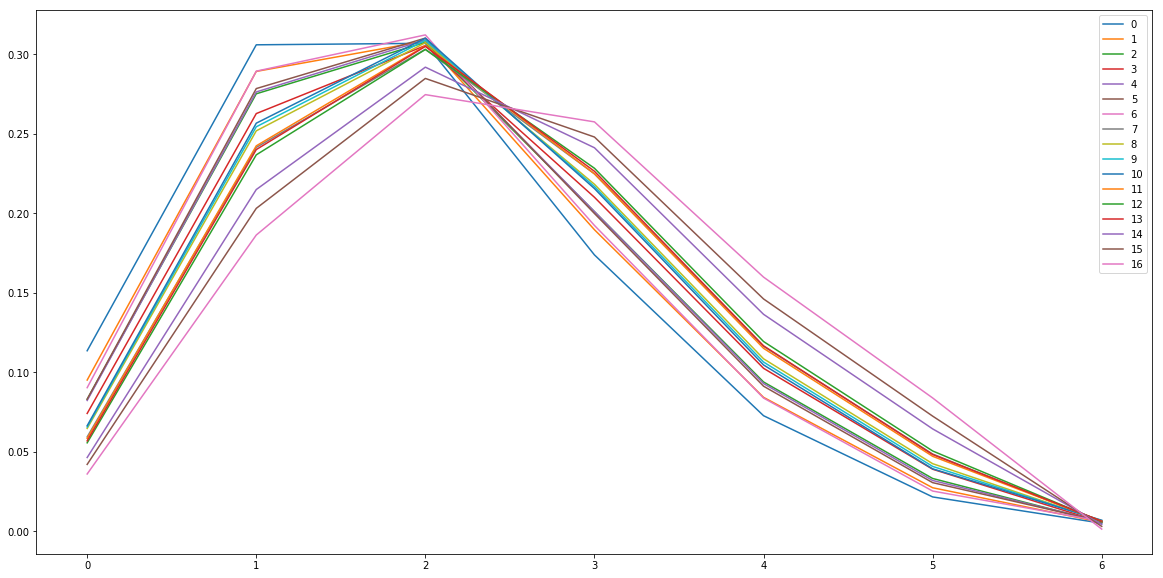

In [75]:
for i,r in enumerate(results):
    plt.plot(range(7), r['posterior_predictive'], label=i)
plt.legend()

In [77]:
bucket_order = list(buckets.values())
bucket_order

['bad', 'meh', 'ok', 'good', 'great']

In [83]:
{k: results[0]['prior'][v] for k,v in buckets.items()}

{1: 0.004676365795724466,
 2: 0.13539192399049885,
 3: 0.46028800475059384,
 4: 0.32066508313539194,
 5: 0.07897862232779097}

### how DB is bucketed over time

Another noisy graph, but pay attention to the blue line representing week 0 and the pink line that shoots up to the far right, representing the results after the last game of the season when he finished with 5 TDs.

The x-axis here is indicative of the scale from 'bad' to 'great'. Up and to the right is better.

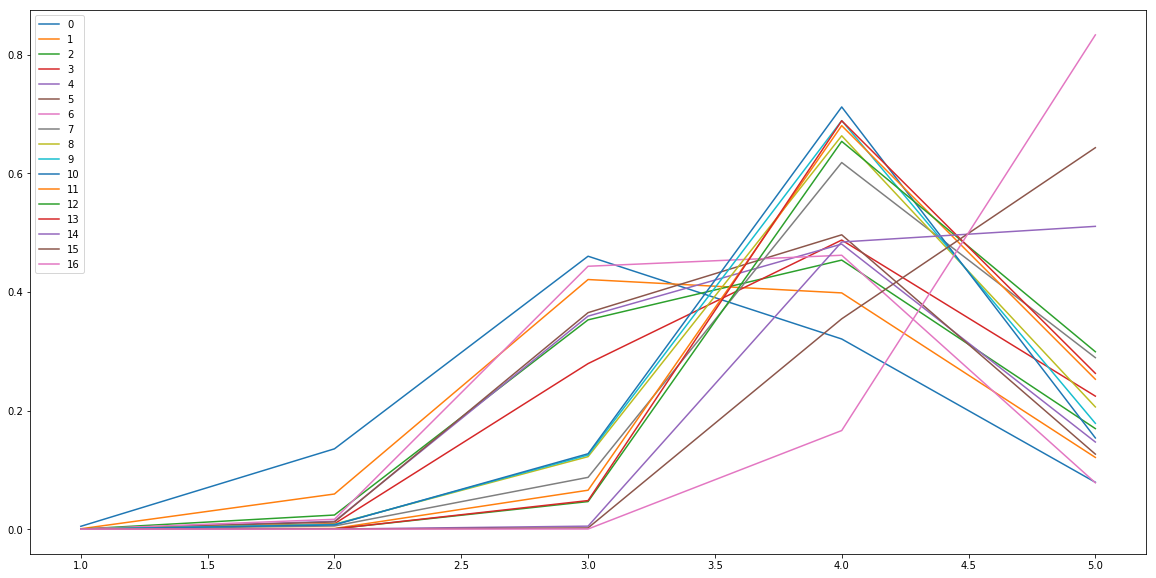

In [85]:
for i,r in enumerate(results):
    ordered_prior = {k: r['prior'][v] for k,v in buckets.items()}
    plt.plot(list(ordered_prior.keys()), list(ordered_prior.values()), label=i)
plt.legend()

### expected values over time

This is what Drew Brees's expected TDs / game looks like as the season progresses. Less movement than I anticipated.

In [87]:
expected_values = [
    sum(i*x for i,x in enumerate(r['posterior_predictive']))
    for r in results
]

(0, 3)

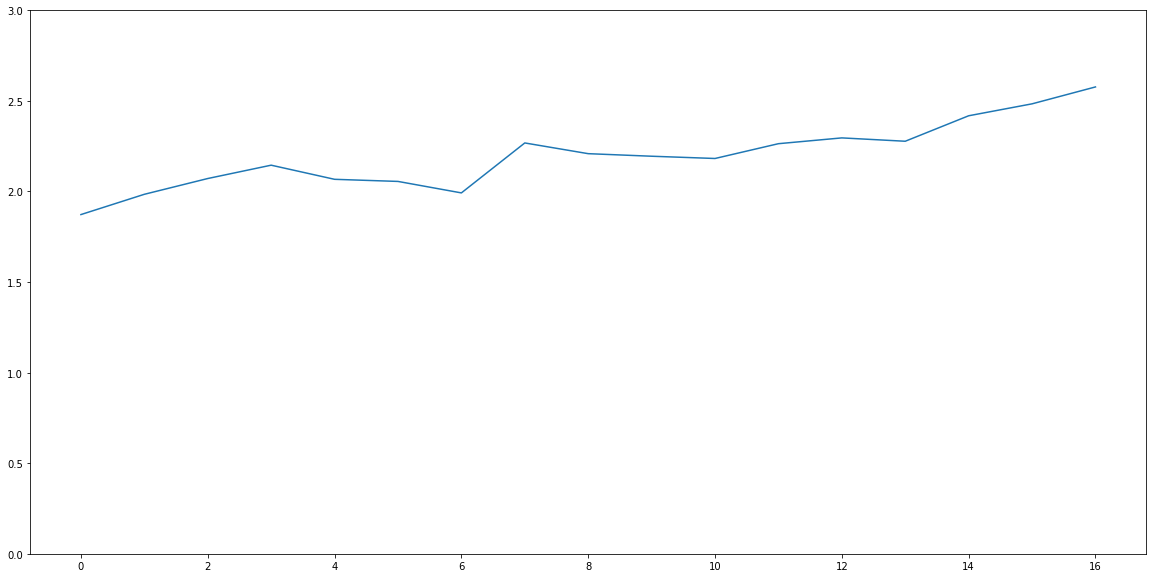

In [95]:
plt.plot(expected_values)
axes = plt.gca()
axes.set_ylim((0,3))

### TDs / game distributions at beginning and end of season

This graph is more informative than the ones above, which shows clearly that by the end of the season our model has figured out that Drew Brees was a phenom that year and consequently assigned way greater probabilities to him having huge games than it did at the start of the season. It works!

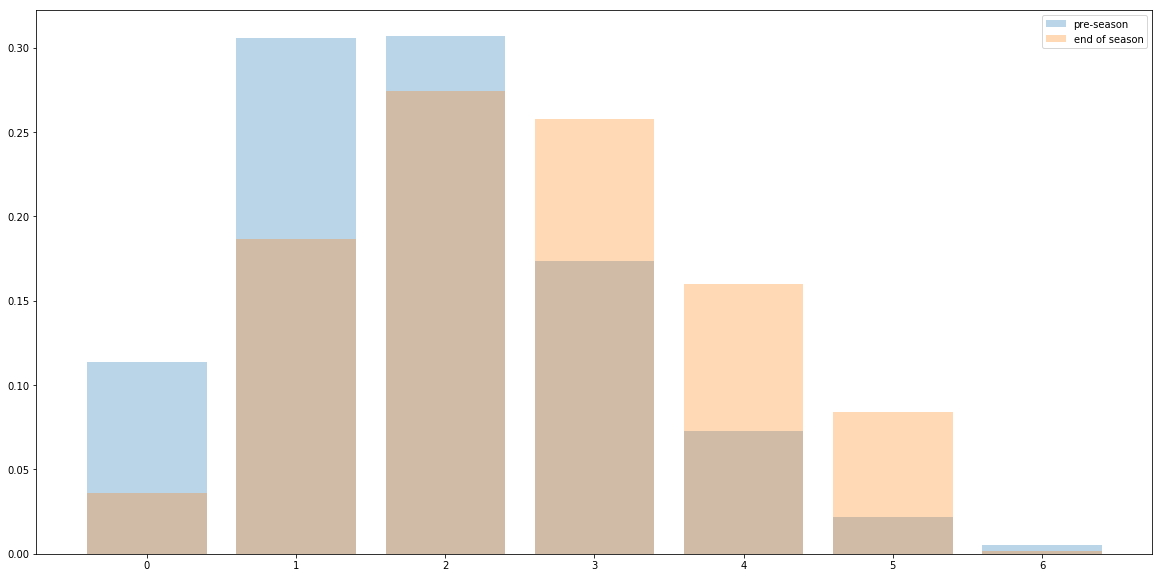

In [96]:
plt.bar(range(7), results[0]['posterior_predictive'], alpha=0.3, label='pre-season')
plt.bar(range(7), results[-1]['posterior_predictive'], alpha=0.3, label='end of season')
plt.legend()